<a href="https://colab.research.google.com/github/leajag/2025_ML_EES/blob/main/Final_project_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is converted from the source: https://www.coursera.org/learn/getting-started-with-tensor-flow2

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import matplotlib as plt
import pandas as pd


# Extra imports for data pre- processing
!pip install rasterio
import rasterio

!pip install geopandas
import geopandas as gpd

!pip install --upgrade pyshp

!pip install --upgrade shapely

!pip install --upgrade descartes

!pip install --upgrade rtree

from __future__ import print_function

from osgeo import ogr

#for CNN
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.utils import plot_model
from sklearn.model_selection import train_test_split




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive

'Albedo img'	    GEEDiT_export_LJ.geojson  'notebooks glacier'
'Colab Notebooks'   ML_project		      'RGB img'


In [3]:
file = "/content/drive/MyDrive/ML_project/dataset_davos_wiesen.tif"

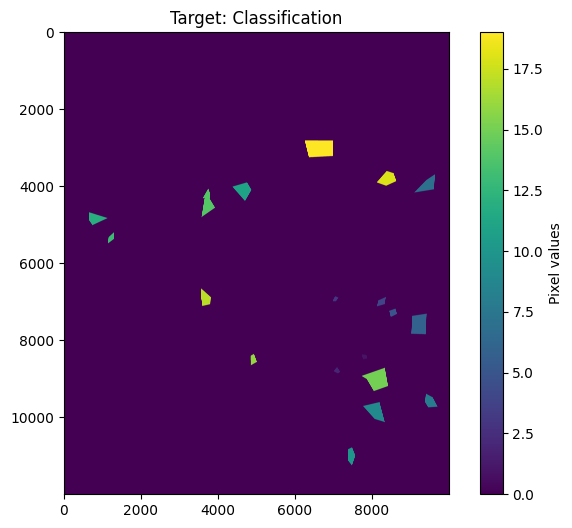

Number of bands: 9


In [5]:
#code from ChatGPT
import matplotlib.pyplot as plt
with rasterio.open(file) as src:
    band3 = src.read(3)
    plt.figure(figsize=(8,6))
    plt.imshow(band3, cmap='viridis')
    plt.colorbar(label="Pixel values")
    plt.title("Target: Classification")
    plt.show()

    print("Number of bands:", src.count)

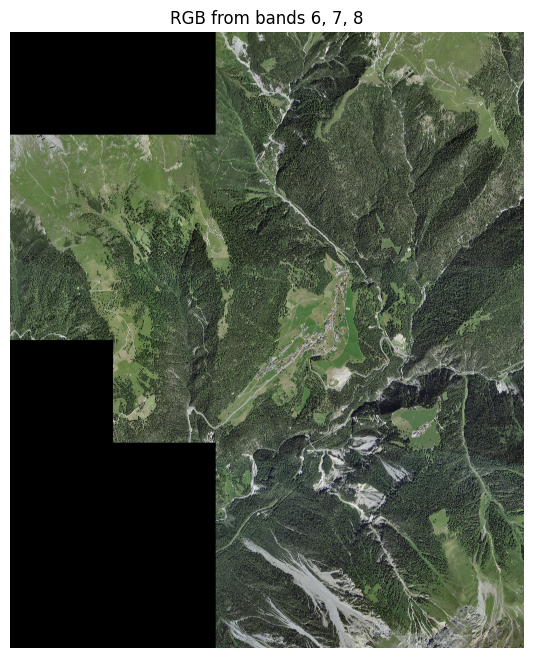

In [6]:

with rasterio.open(file) as src:
    r = src.read(6)
    g = src.read(7)
    b = src.read(8)

rgb = np.dstack((r, g, b))
rgb_uint8 = rgb.astype("uint8") #statt float nur noch integer

plt.figure(figsize=(8,8))
plt.imshow(rgb_uint8)
plt.title("RGB from bands 6, 7, 8")
plt.axis("off")
plt.show()

In [4]:
########classifcation ändern von target band 3
with rasterio.open(file) as src:
    band3 = src.read(3)

classified = np.zeros_like(band3, dtype=np.uint8)

classified[(band3 >= 1) & (band3 <= 3)]  = 1
classified[(band3 >= 4) & (band3 <= 7)]  = 2
classified[(band3 >= 8) & (band3 <= 10)] = 3
classified[(band3 >= 11) & (band3 <= 15)] = 4
classified[(band3 >= 16) & (band3 <= 19)] = 5





In [5]:
file = "/content/drive/MyDrive/ML_project/dataset_davos_wiesen.tif"
output = "/content/drive/MyDrive/ML_project/target_classified_davos_wiesen.tif"

with rasterio.open(file) as src:
    band3 = src.read(3)

    # Profil anpassen
    profile = src.profile
    profile.update(dtype=rasterio.uint8, count=1)

    # Klassifikation: Beispiel wie vorher
    classified = np.zeros_like(band3, dtype=np.uint8)
    classified[(band3 >= 1) & (band3 <= 3)]  = 1
    classified[(band3 >= 4) & (band3 <= 7)]  = 2
    classified[(band3 >= 8) & (band3 <= 10)] = 3
    classified[(band3 >= 11) & (band3 <= 15)] = 4
    classified[(band3 >= 16) & (band3 <= 19)] = 5

    # Neues TIFF speichern
    with rasterio.open(output, "w", **profile) as dst:
        dst.write(classified, 1)

KeyboardInterrupt: 

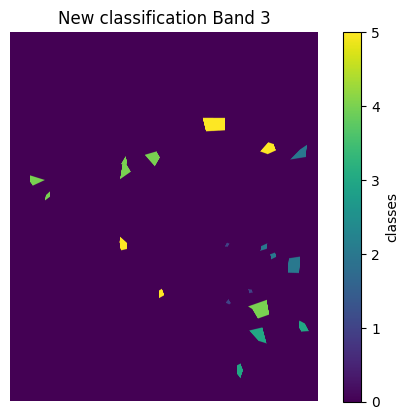

In [7]:
import matplotlib.pyplot as plt

plt.imshow(classified)
plt.colorbar(label="classes",  cmap=plt.cm.Spectral)
plt.title("New classification Band 3")
plt.axis("off")
plt.show()

In [ ]:
#RGB bänder stacken
with rasterio.open(file) as src:
    bands_to_use = [6, 7, 8]   # all except band 3 (target)

    stacked = []
    for b in bands_to_use:
        stacked.append(src.read(b))

    stacked = np.stack(stacked)  # Shape: (8, H, W)

In [6]:
#alle bànder stacken ausser 3
with rasterio.open(file) as src:
    bands_to_use = [1, 2, 4, 5, 6, 7, 8, 9]   # all except band 3 (target)

    stacked = []
    for b in bands_to_use:
        stacked.append(src.read(b))

    stacked = np.stack(stacked)  # Shape: (8, H, W)

In [9]:
file = "/content/drive/MyDrive/ML_project/dataset_davos_wiesen.tif"
output = "/content/drive/MyDrive/ML_project/dataset_davos_wiesen_input.tif"

with rasterio.open(file) as src:
    profile = src.profile


# Profil anpassen:
profile.update(
    count=len(bands_to_use),  # 8 Bänder
    dtype=stacked.dtype
)

# Neues TIFF speichern
with rasterio.open(output, "w", **profile) as dst:
    dst.write(stacked)


In [ ]:
#Julia Walker:
#Code adapted from "classification of land cover" tutorial by Chris Holden
#https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

#Pairing X (spectral bands) with Y(land cover class labels) for training data

# How many training data samples?¨


#roi = target
n_samples = (classified).sum()
print('We have {n} samples'.format(n=n_samples))


# What are our classification labels?
labels = np.unique(classified[classified])
print('The training data include {n} classes: {classes}'.format(n=labels.size,
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows


X = stacked[classified, :]
y = classified[classified]


print('X matrix is sized: {sz}'.format(sz=X.shape))
print('y array is sized: {sz}'.format(sz=y.shape))

We have 6478508 samples


In [ ]:
# Import the Eurosat data
def load_eurosat_data():
    data_dir = '/root/.cache/pooch/a03aa179d211d203a83480995708754e-EUB7KobuofVIs9kbBlPsh8wByNhXgThqpzijsFCViy9wHw.unzip/data_cnn'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    x_val  = np.load(os.path.join(data_dir, 'x_test.npy'))
    y_val  = np.load(os.path.join(data_dir, 'y_test.npy'))
    return (x_train, y_train), (x_val, y_val)

(X_train, y_train), (X_val_test, y_val_test) = load_eurosat_data()
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

#Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

## Q1 Build a CNN `model1` to classify Eurosat data.

Let's construct a CNN called 'model1' using the Sequential API, according to the following specifications:

* The model should use the input_shape in the function argument to set the input size in the first layer.
* The first layer should be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer should also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer should be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer should be a Flatten layer, named 'flatten'.
* The fifth layer should be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer should be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network should have 6 layers.

In [ ]:
# Initiate an empty Sequential model
model1 = tf.keras.Sequential()

In [ ]:
# Assign value to input_shape variable
input_shape = X_train.shape

In [ ]:
# Add the first layer 'conv_1': a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding.
# Ensure the weights are initialised by providing the input_shape argument in the first layer.
model1.add(tf.keras.layers.Conv2D(16,(3,3),padding='SAME', activation='relu',input_shape=input_shape[1:],name='conv_1'))

In [ ]:
# Add the second layer 'conv_2': a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding.
model1.add(tf.keras.layers.Conv2D(8,(3,3),padding='SAME', activation='relu',name='conv_2'))
# Add the third layer 'pool_1': a MaxPooling2D layer with a pooling window size of 8x8.
model1.add(MaxPooling2D((8,8),name='pool_1'))
# Add the fourth layer 'flatten': a Flatten layer.
model1.add(tf.keras.layers.Flatten(name='flatten'))
# Add the fifth layer 'dense_1': a Dense layer with 32 units, a ReLU activation.
model1.add(tf.keras.layers.Dense(32, activation='relu',name='dense_1'))
# Add the sixth layer 'dense_2': a Dense layer with 10 units and softmax activation.
model1.add(tf.keras.layers.Dense(10,activation='softmax',name='dense_2'))
# Print the model summary
model1.summary()

❓❓❓ Do you have a model of the following structure?     



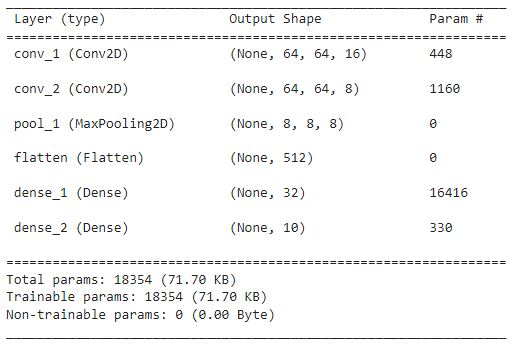

## Q2 Compile `model1` with your chosen optimiser, loss function, and an evalutation metric.

* Compile `model1` with the Adam optimiser, sparse categorical cross entropy loss function, and a single accuracy metric.

In [ ]:
# Compile the model with the Adam optimiser, sparse categorical cross entropy loss function, and a single accuracy metric.
model1.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

## Q3 Evaluate the initial accuracy of `model1`: Is the initial accuracy of the model as you have expected?



In [ ]:
# Calculate its initialised test accuracy
test_loss, test_acc = model1.evaluate(x=X_train, y=y_train, verbose=1)
print('Test accuracy: {acc:0.3f}'.format(acc=test_acc)) ##########0.102 bad accuracy because first run, not yet trained on the whole training set


❓❓❓ Does your model have a similar initial accuracy & why?     


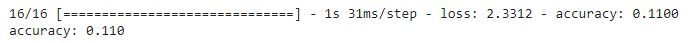

## Q4 Train `model1` with 15 epochs, store the result in variable 'history';
* Store the fitting result in a variable history;


In [ ]:
# Fit the model with 15 epochs and store the fitting result in a variable history.
epochs = 15

history = model1.fit(X_train, y_train,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_val, y_val)) #more or less similar (attention: columns not organised in same order)

❓❓❓ Do you have similar print output?



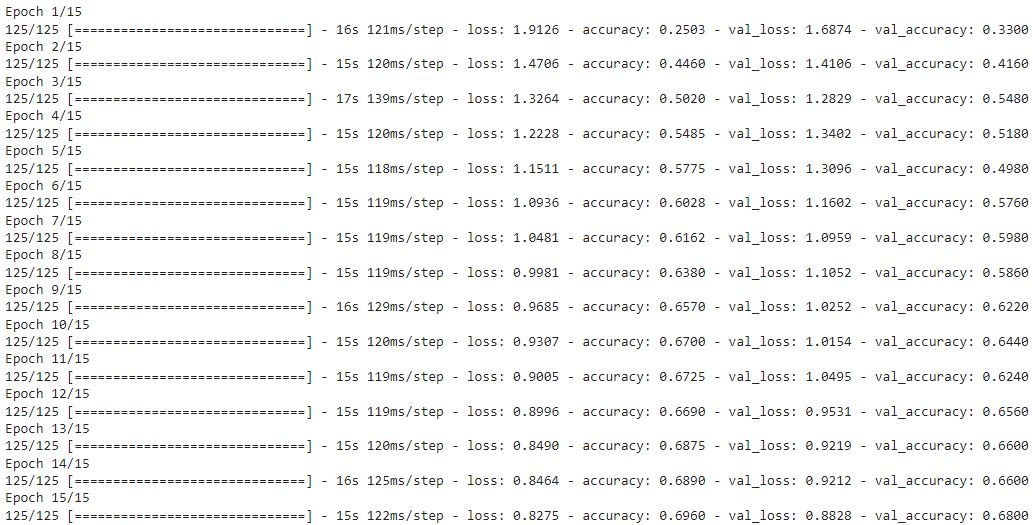

## Q5 Evaluate the accuracy of fitted `model1`, plot training, validation set loss and accuracy, and plot the model using Keras model plotting utilities

* Evaluate the fitted model
    * What's the test accuracy after training the model? Does it improve from the initialization?
* Plot the model using [Keras model plotting utilities](https://keras.io/api/utils/model_plotting_utils/)

In [ ]:
# Calculate the test accuracy
score = model1.evaluate(x=X_test, y=y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=score[1]))  ###############accuracy on test set: 0.676

❓❓❓ Do you have similar test accuracy?


Capture3.JPG

In [ ]:
# Plot training, validation set loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

❓❓❓ Do you have a similar plot?


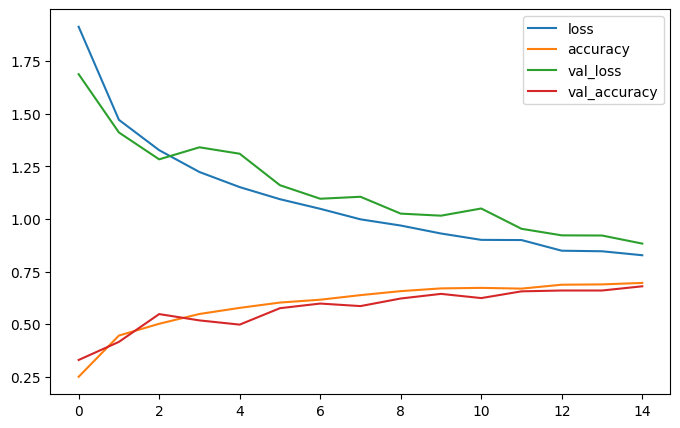

In [ ]:
# Plot the model using Keras model plotting utilities
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True, dpi=50 )

❓❓❓ Do you have a similar plot?   


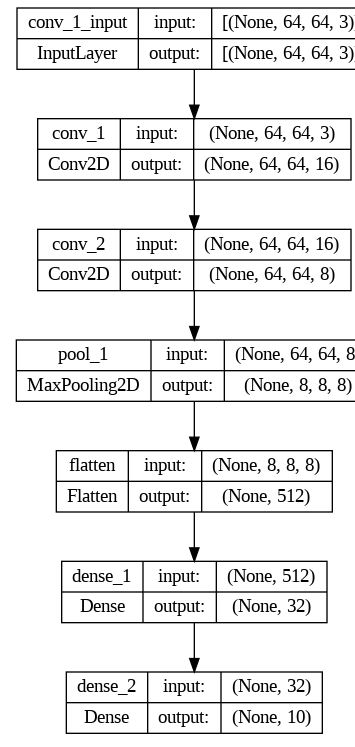

## Q6 Create two callbacks to save the model weights at each epoch and the best validation accuracy epoch

1.`checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training;
2. `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy.

In [ ]:
# Create a ModelCheckpoint object that:
#     - saves the weights only at the end of every epoch
#     - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
#     - generates filenames in that directory like 'checkpoint_XXX' where
#       XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.

path_every = 'checkpoints_every_epoch/checkpoint_{epoch:03d}.weights.h5'
checkpoint_every_epoch = ModelCheckpoint(filepath=path_every,
                           save_freq="epoch",
                           save_weights_only=True,
                           monitor = "loss",
                           verbose=0)

In [ ]:
# Create a ModelCheckpoint object that:
#     - saves only the weights that generate the highest validation accuracy
#     - saves into a directory called 'checkpoints_best_only' inside the current working directory
#     - generates a file called 'checkpoints_best_only/checkpoint'


path_best = 'checkpoints_best_only/checkpoint.weights.h5'
checkpoint_best_only = ModelCheckpoint(filepath=path_best,
                           save_freq="epoch",
                           save_weights_only=True,
                           save_best_only = True,
                           monitor = "val_accuracy",
                           verbose=1)

## Q7 Build a CNN `model` with the same initial structure as `model1` and train for 15 epochs using the callbacks from Q6

Now, you will train the model using the three callbacks you created. If you created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

You should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [ ]:
# Create a model with the same initial structure as model1 again from scratch
input_shape = X_train[0].shape

model = Sequential([
        Conv2D(16,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_1'),
        Conv2D(8,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_2'),
        MaxPooling2D((8,8),name='pool_1'),
        Flatten(name='flatten'),
        Dense(32, activation='relu',name='dense_1'),
        Dense(10,activation='softmax',name='dense_2')
    ])

model.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
# Train model using the callbacks you just created with 15 epochs

callbacks = [checkpoint_every_epoch, checkpoint_best_only]
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), callbacks=callbacks)

❓❓❓ Do you have similar print output?

 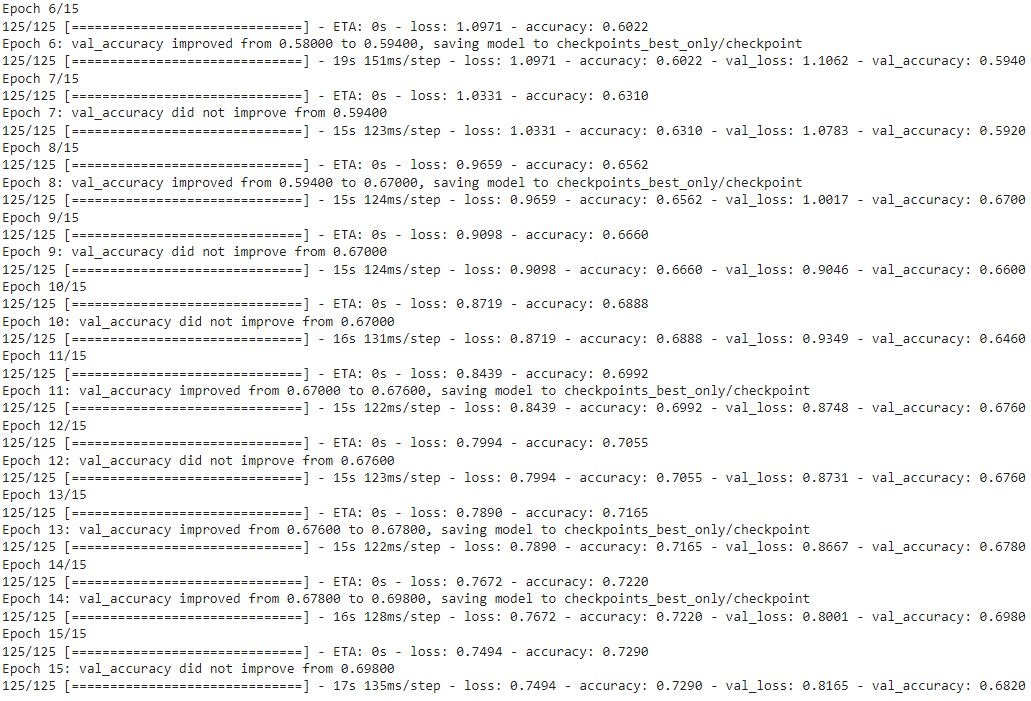

## Q8 Create new models `model_last_epoch` and `model_best_epoch` with model1 initial structure; load weights from the latest saved epoch and the saved epoch with the highest validation accuracy respectively

Now you will use the weights you just saved in a fresh model. You should create two functions, both of which take a freshly instantiated model instance:
- `model_last_epoch` should contain the weights from the latest saved epoch
- `model_best_epoch` should contain the weights from the saved epoch with the highest testing accuracy

_Hint: use the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [ ]:
# Create a new CNN with same structure as model1 and compile
input_shape = X_train[0].shape

model_last_epoch = Sequential([
        Conv2D(16,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_1'),
        Conv2D(8,(3,3),padding='SAME', activation='relu',name='conv_2'),
        MaxPooling2D((8,8),name='pool_1'),
        Flatten(name='flatten'),
        Dense(32, activation='relu',name='dense_1'),
        Dense(10,activation='softmax',name='dense_2')
    ])
model_last_epoch.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

# Load on the weights from the last training epoch.
model_last_epoch.load_weights("checkpoints_every_epoch/checkpoint_015.weights.h5")




In [ ]:
# Create a new CNN with same structure as model1 and compile
input_shape = X_train[0].shape

model_best_epoch = Sequential([
        Conv2D(16,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_1'),
        Conv2D(8,(3,3),padding='SAME', activation='relu',name='conv_2'),
        MaxPooling2D((8,8),name='pool_1'),
        Flatten(name='flatten'),
        Dense(32, activation='relu',name='dense_1'),
        Dense(10,activation='softmax',name='dense_2')
    ])
model_best_epoch.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

# Load the weights leading to the highest validation accuracy.
model_best_epoch.load_weights('checkpoints_best_only/checkpoint.weights.h5')

In [ ]:
################################?????????????###############################
#Verify that the validation accuarcy of the last and the best model.

score = model_last_epoch.evaluate(X_val, y_val, verbose=0) ###############accuracy: 0.68 same accuracy right?
print('Model validation accuracy with last epoch weights: {acc:0.3f}'.format(acc=score[1]))
print('')

score = model_best_epoch.evaluate(X_val, y_val, verbose=0) ################accuracy: 0.68
print('Model validation accuracy with best epoch weights: {acc:0.3f}'.format(acc=score[1]))

❓❓❓ Are the saved models' validation accuracy as expected?

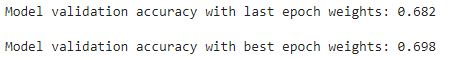

## Q9 Explore to improve the model performance by trying to reduce the bias: design and train a model2
* For example, train a CNN called model2, which has the same structure as model1, but with more convolution units: `conv_1` has 32 units, `conv_2` has 64 units, `dense_1` with 256 units

❓❓❓
* Does the model performance improve?
* What are other potential strategies to improve model performance by reducing the bias?

In [ ]:
# Build a Sequential model model2 with same specification as the previous model1,
# but change the number of filters in the first convolution layer to 32 and second convolution layer to 64, the dense_1 layer to 256 units.
# Ensure the weights are initialised by providing the input_shape argument in the first layer.
input_shape = X_train[0].shape

model2 = Sequential([
        Conv2D(32,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_1'),
        Conv2D(64,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_2'),
        MaxPooling2D((8,8),name='pool_1'),
        Flatten(name='flatten'),
        Dense(256, activation='relu',name='dense_1'),
        Dense(10,activation='softmax',name='dense_2')
    ])
model2.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
# Train the model and store the results in a variable called history
history = model2.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

❓❓❓ Are your printed output similar to the following screenshot?


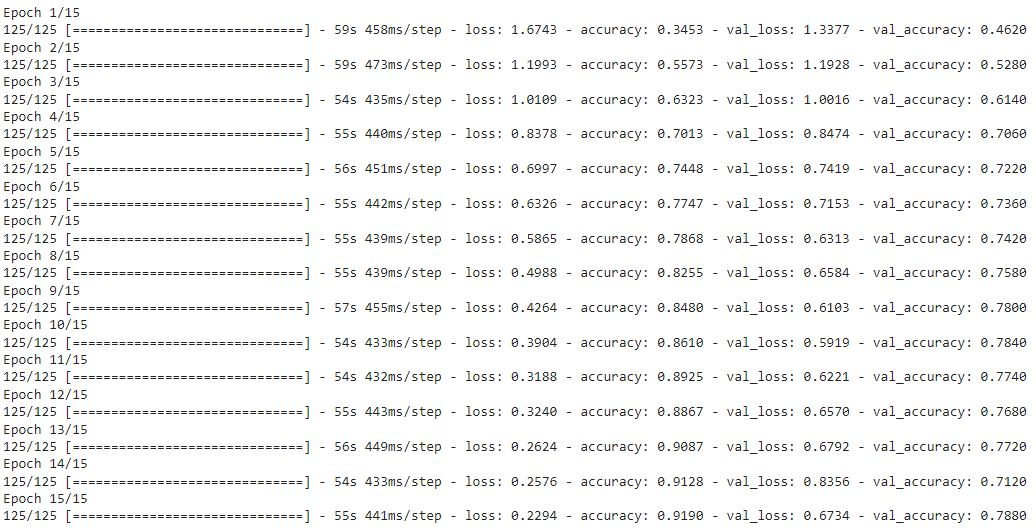

In [ ]:
# Calculate the test accuracy
score = model2.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=score[1])) ########0.804

❓❓❓ Does your model's test accuracy improve and why?


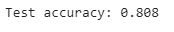

## Q10 Explore to improve the model performance by trying to reduce the variance: design and train a `model3`
* For example, train a CNN called `model3`, which has the same structure as `model2`, add dropout layers one after the max pooling layer, one before the final dense layer with dropout rate of 0.2.

❓❓❓
* Does the model performance improve?
* What are other potential strategies to improve model performance by reducing the variance?

In [ ]:
# Build a Sequential model model3 with same specification as the previous model2,
# but add two dropout layers - one after the max pooling layer, one before the final dense layer.
# Ensure the weights are initialised by providing the input_shape argument in the first layer.
input_shape = X_train[0].shape

model3 = Sequential([
        Conv2D(32,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_1'),
        Conv2D(64,(3,3),padding='SAME', activation='relu',input_shape=input_shape,name='conv_2'),
        MaxPooling2D((8,8),name='pool_1'),
        Dropout(rate = 0.2),
        Flatten(name='flatten'),
        Dense(256, activation='relu',name='dense_1'),
        Dropout(rate = 0.2),
        Dense(10,activation='softmax',name='dense_2')
    ])
model3.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
# Train the model and store the results in a variable called history
history = model3.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

❓❓❓ Are your printed output similar to the following screenshot?

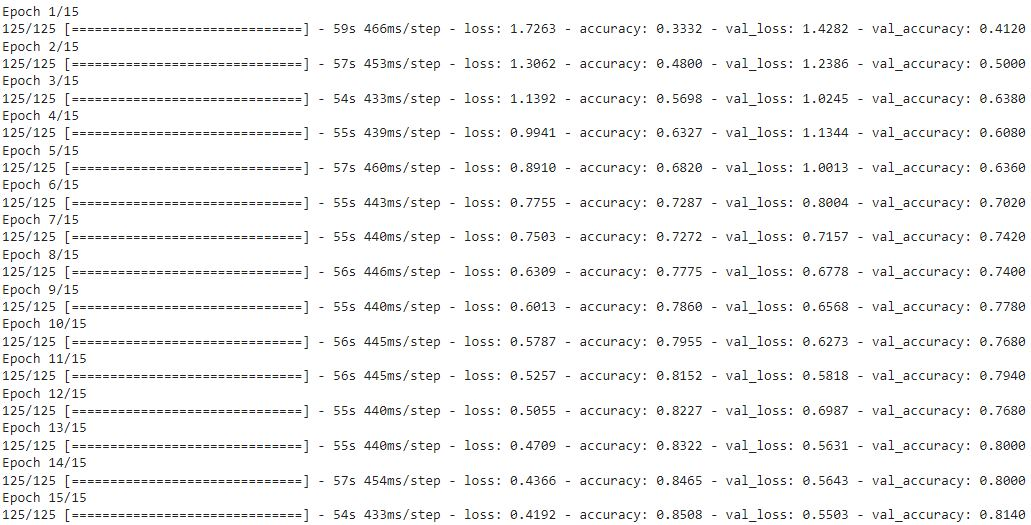

In [ ]:
# Calculate the test accuracy
score = model3.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=score[1])) ############0.818

❓❓❓ Does your model's test accuracy improve and why?


Capture11.JPG

## Q11 Explore to improve the model performance using transfer learning from pretrained model

* Use pretrained models from Keras Applications [vgg16 ](https://keras.io/api/applications/vgg/#vgg16-function)

    * Does the model performance improve after the above explorations?
    * How would you further improve the model performance?

In [ ]:
from keras.applications import VGG16


conv_base = VGG16(include_top=False, input_shape = input_shape)
# freeze the weights
for layer in conv_base.layers:
    layer.trainable = False

model4 = Sequential([
        conv_base,
        Flatten(name='flatten'),
        Dropout(0.2),
        Dense(256, activation='relu',name='dense_1'),
        Dropout(0.2),
        Dense(10,activation='softmax',name='dense_2')
    ])
model4.compile(optimizer='adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics = ['accuracy'])

In [ ]:
history = model4.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val))

❓❓❓ Are your printed output similar to the following screenshot? It takes a really long time to train ...


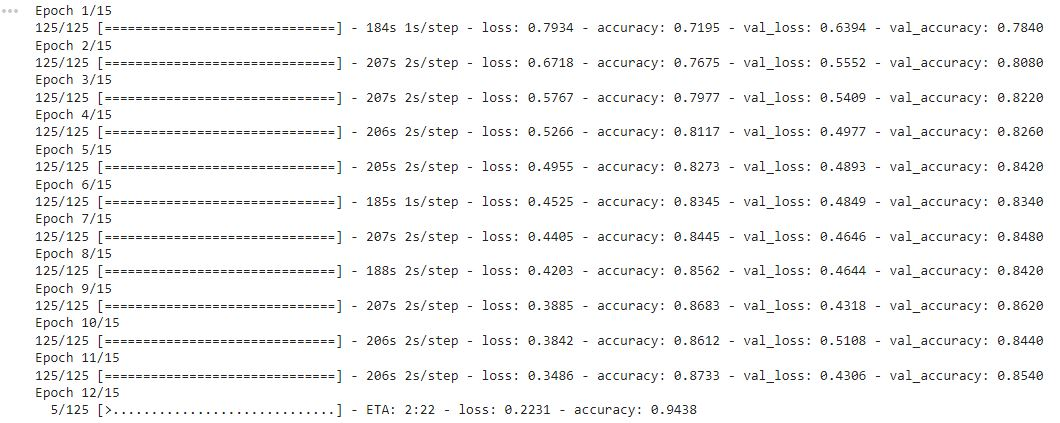

In [ ]:
# Calculate the test accuracy
score = model4.evaluate(X_test, y_test, verbose=0)
print('Test accuracy: {acc:0.3f}'.format(acc=score[1])) #########0.836

✌✌✌ Congratulations! You have completed this exercise. Now you know how to train CNNs to classify remote sensing images.

Still, the accuracy reported from the Eurosat dataset paper - Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification is 98.57%. ⚡⚡⚡Have you found strategies to improve the performance to that level?